# Performance Analysis

In this chapter we analyze the behavior of the various node coloring algorithms in the ``gcol`` library. Where appropriate, we also make comparisons to similar algorithms from the ``networkx`` library. 

Here, algorithms are evaluated by looking at solution quality and run times. Details on algorithm complexity (in terms of big O notation) can be found in ``gcol``'s documentation. Here, all tests are conducted on randomly generated [Erdos-Renyi](https://en.wikipedia.org/wiki/Erdos-Renyi_model) graphs, commonly denoted by $G(n,p)$. These graphs are constructed by taking $n$ nodes and adding an edge between each node pair at random with probability $p$. The expected number of edges in a $G(n,p)$ graph is therefore $\binom{n}{2}p$, while the expected node degree is $(n-1)p$. 

For these tests, we use differing values for $n$ but keep $p$ fixed at $0.5$. This is due to a [result](https://mathoverflow.net/questions/424327/selection-of-an-n-node-graph-at-random) of [Nick Wormald](https://en.wikipedia.org/wiki/Nick_Wormald), who has established that for $n \gtrapprox 30$, a set of randomly constructed $G(n, 0.5)$ graphs can be considered equivalent to a random sample from the population of *all* unlabeled $n$-node graphs. This allows us to make general statistical statements about performance across the set of all $n$-node graphs, although different observations may well be made when executing these algorithms on specifically chosen topologies, such as [scale-free graphs](https://en.wikipedia.org/wiki/Scale-free_network) and [planar graphs](https://en.wikipedia.org/wiki/Planar_graph). Examples of these differences are discussed in this [book](https://link.springer.com/book/10.1007/978-3-030-81054-2), where a wider set of trials is conducted.

In the code below, each trial involves generating a set of $G(n,0.5)$ graphs using a range of values of $n$. The results of the algorithms are then written to a Pandas dataframe ``df``, aggregated in a ``pivot`` table, and summarized in charts. Lines in the charts give mean values, while the shaded areas indicate one standard deviation on either side of these means. All results below were found by executing the code on a 3.0 GHtz Windows 11 PC with 16 GB of RAM.

We start by importing the libraries we need.

In [2]:
import pandas as pd
import networkx as nx
import gcol
import matplotlib.pyplot as plt
import time

## Differing Node Coloring Strategies

In our first experiment, we compare the different constructive strategies available for node coloring in the ``gcol`` library (namely ``'random'``, ``'welsh_powell'``, ``'dsatur'``, and ``'rlf'``) using $G(n,0.5)$ graphs with values of $n$ between $50$ and $500$. The results are shown in the charts below. Further details on these algorithms can be found in ``gcol``'s documentation.

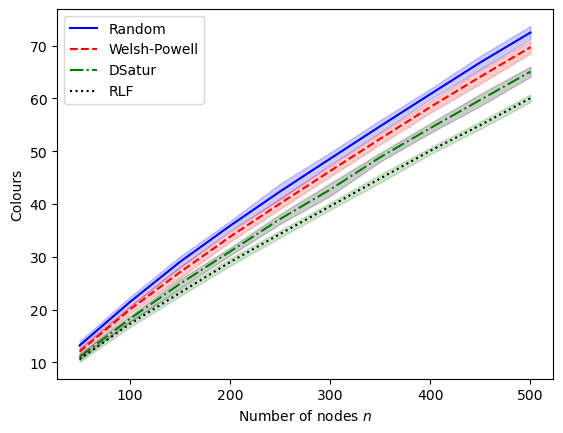

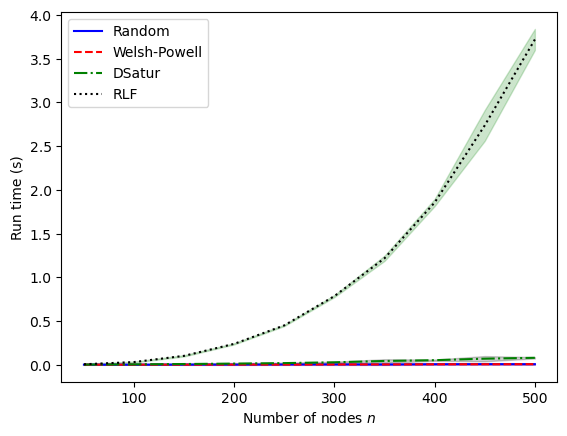

In [1]:
#Carry out the trials and put the results into a list
results = []
nVals = range(50,501,50)
for n in nVals:
    for seed in range(50):
        G = nx.gnp_random_graph(n, 0.5, seed)
        for strategy in ["random", "welsh_powell", "dsatur", "rlf"]:
            start = time.time()
            c = gcol.node_coloring(G, strategy)
            results.append([n, seed, strategy, max(c.values()) + 1, time.time()-start])
            
# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["n", "seed", "strategy", "cols", "time"])
pivot = df.pivot_table(columns='strategy', aggfunc=['mean','std'], values=['cols','time'], index='n')

# Now use the pivot table to make a chart that compares mean solution quality
mean1, SD1 = pivot[("mean","cols","random")], pivot[("std","cols","random")]
mean2, SD2 = pivot[("mean","cols","welsh_powell")], pivot[("std","cols","welsh_powell")]
mean3, SD3 = pivot[("mean","cols","dsatur")], pivot[("std","cols","dsatur")]
mean4, SD4 = pivot[("mean","cols","rlf")], pivot[("std","cols","rlf")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='Random')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='Welsh-Powell')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='DSatur')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='RLF')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Colours")
plt.legend()
plt.show()

# and do the same for mean run times
mean1, SD1 = pivot[("mean","time","random")], pivot[("std","time","random")]
mean2, SD2 = pivot[("mean","time","welsh_powell")], pivot[("std","time","welsh_powell")]
mean3, SD3 = pivot[("mean","time","dsatur")], pivot[("std","time","dsatur")]
mean4, SD4 = pivot[("mean","time","rlf")], pivot[("std","time","rlf")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='Random')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='Welsh-Powell')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='DSatur')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='RLF')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

The results above show that the ``random`` and ``welsh-powell`` strategies produce the poorest solutions overall (in terms of the number of colors they use) while the RLF algorithm produces the best. This gap also seems to widen for larger values of $n$. On the other hand, the RLF algorithm has less favorable run times, as shown in the second chart. This is to be expected because the RLF algorithm has a higher complexity than the other options. A good compromise seems to be struck by the ``dsatur`` strategy, which features comparatively good solution quality and run times.

## Optimization Output

The following code demonstrates how the ``verbose`` parameter can be used to produce run-time output for the various optimization algorithms. This allows us to assess algorithm performance.

In [14]:
G = nx.gnp_random_graph(50, 0.5)
c = gcol.node_coloring(G, strategy="welsh_powell", opt_alg=1, verbose=1)

Running backtracking algorithm:
    Found solution with 13 colors. Total backtracking iterations = 0
    Found solution with 12 colors. Total backtracking iterations = 52
    Found solution with 11 colors. Total backtracking iterations = 1293
    Found solution with 10 colors. Total backtracking iterations = 28972977
Ending backtracking at iteration 34324898 - optimal solution achieved.


In the above example, the initial solution has used 13 colors. The backtracking algorithm (``opt_alg=1``) has been used to reduce the number of colors, eventually finding an optimal solution. We can do similar things with the other optimization algorithms while controlling their number of iterations:

In [15]:
G = nx.gnp_random_graph(50, 0.5)
c = gcol.node_coloring(G, strategy="welsh_powell", opt_alg=2, it_limit=10000, verbose=1)

Running local search algorithm:
    Found solution with 12 colors. Total local search iterations = 0 / 10000
    Found solution with 11 colors. Total local search iterations = 12 / 10000
    Found solution with 10 colors. Total local search iterations = 241 / 10000
Ending local search. Iteration limit of 10000 has been reached.


In some cases, we can also increase the amount of output by using a larger value with ``verbose``:

In [17]:
G = nx.gnp_random_graph(50, 0.5)
c = gcol.node_coloring(G, strategy="welsh_powell", opt_alg=3, it_limit=10000, verbose=2)

Running local search algorithm:
    Found solution with 12 colors. Total local search iterations = 0 / 10000
    Running PartialCol algorithm using 11 colors
        Solution with 11 colors and cost 5 found by PartialCol at iteration 0
        Solution with 11 colors and cost 4 found by PartialCol at iteration 1
        Solution with 11 colors and cost 3 found by PartialCol at iteration 2
        Solution with 11 colors and cost 2 found by PartialCol at iteration 3
        Solution with 11 colors and cost 1 found by PartialCol at iteration 4
        Solution with 11 colors and cost 0 found by PartialCol at iteration 6
    Ending PartialCol
    Found solution with 11 colors. Total local search iterations = 6 / 10000
    Running PartialCol algorithm using 10 colors
        Solution with 10 colors and cost 5 found by PartialCol at iteration 0
        Solution with 10 colors and cost 4 found by PartialCol at iteration 1
        Solution with 10 colors and cost 3 found by PartialCol at iter

## Comparison to NetworkX

The next set of experiments compares the performance of ``gcol``'s local search routines and NetworkX's [interchange coloring routine](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.coloring.greedy_color.html). As a benchmark, we also include ``gcol``'s ``dsatur`` option from earlier, which is also used to produce the initial solutions for the local search algorithms. For comparative purposes, two of ``gcol``'s local search algorithms (``opt_alg=2`` and ``opt_alg=3``) are used here, and we impose a fixed iteration limit of $n$. The results are collected and displayed in the same manner as the previous example.

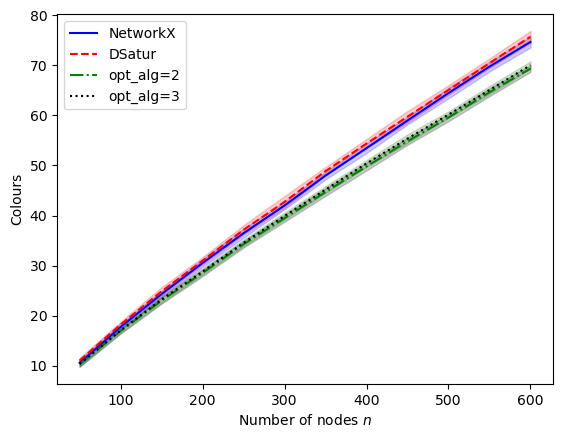

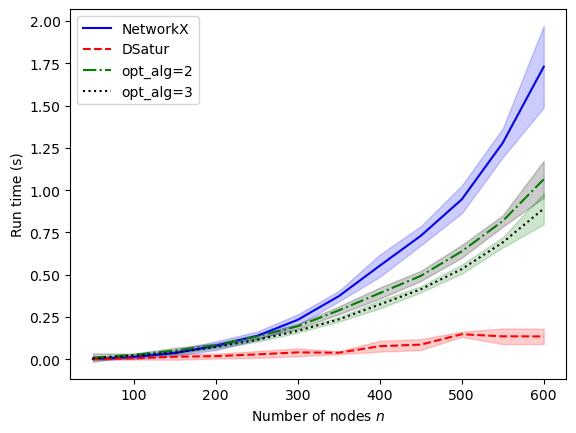

In [2]:
#Carry out the trials and put the results into a list
results = []
nVals = range(50,601,50)
for n in nVals:
    for seed in range(50):
        G = nx.gnp_random_graph(n, 0.5, seed)
        start = time.time()
        c = nx.greedy_color(G, "largest_first", interchange=True)
        results.append([n, seed, "networkx", max(c.values()) + 1, time.time()-start])
        start = time.time()
        c = gcol.node_coloring(G)
        results.append([n, seed, "dsatur", max(c.values()) + 1, time.time()-start])
        start = time.time()
        c = gcol.node_coloring(G, opt_alg=2, it_limit=len(G))
        results.append([n, seed, "opt_alg=2", max(c.values()) + 1, time.time()-start])
        start = time.time()
        c = gcol.node_coloring(G, opt_alg=3, it_limit=len(G))
        results.append([n, seed, "opt_alg=3", max(c.values()) + 1, time.time()-start])
            
# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["n", "seed", "alg", "cols", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['cols','time'], index='n')

# Use the pivot table to make charts as before
mean1, SD1 = pivot[("mean","cols","networkx")], pivot[("std","cols","networkx")]
mean2, SD2 = pivot[("mean","cols","dsatur")], pivot[("std","cols","dsatur")]
mean3, SD3 = pivot[("mean","cols","opt_alg=2")], pivot[("std","cols","opt_alg=2")]
mean4, SD4 = pivot[("mean","cols","opt_alg=3")], pivot[("std","cols","opt_alg=3")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='DSatur')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='opt_alg=2')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='opt_alg=3')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Colours")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","networkx")], pivot[("std","time","networkx")]
mean2, SD2 = pivot[("mean","time","dsatur")], pivot[("std","time","dsatur")]
mean3, SD3 = pivot[("mean","time","opt_alg=2")], pivot[("std","time","opt_alg=2")]
mean4, SD4 = pivot[("mean","time","opt_alg=3")], pivot[("std","time","opt_alg=3")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='DSatur')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='opt_alg=2')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='opt_alg=3')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

It is clear from the above results that the local search algorithms make significant improvements to the solutions provided by the ``dsatur`` strategy, albeit with additional time requirements. The solutions and run times of these local search algorithms are also superior to NetworkX's node coloring routines. Further improvements in solution quality can usually be found by increasing the iteration limit of the local search algorithms, as demonstrated below.

## Exact Algorithm Performance

In addition to local search, the ``gcol`` library features an exact, exponential-time algorithm for node coloring, based on backtracking. This algorithm is invoked by setting ``opt_alg=1`` (the parameter ``it_limit`` is redundant here). At the start of this algorithm's execution, a large clique $C$ is identified in $G$ using the NetworkX function ``nx.max_clique()``. The nodes of $C$ are then permanently assigned to different colors. The main backtracking algorithm is then executed and only halts only when a solution using $C$ colors has been identified, or when the algorithm has backtracked to the root of the search tree. In both cases the returned solution will be optimal (that is, will be using the minimum number of colors). 

The following code evaluates the performance of this algorithm on $G(n,0.5)$ graphs for a range of $n$-values.

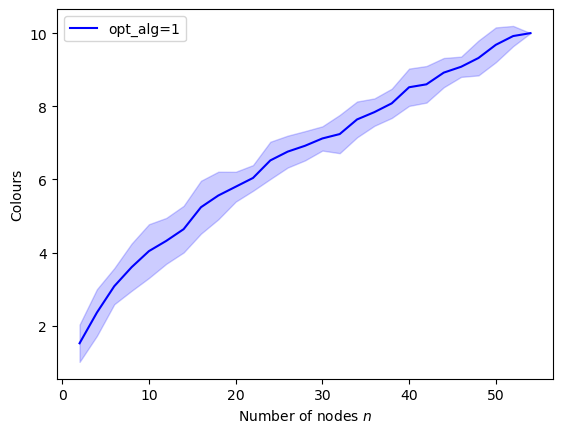

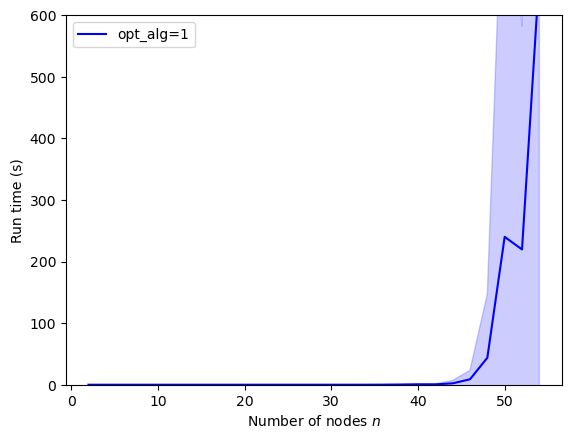

In [4]:
results = []
nVals = range(2,55,2)
for n in nVals:
    for seed in range(25):
        G = nx.gnp_random_graph(n, 0.5, seed)
        start = time.time()
        c = gcol.node_coloring(G, opt_alg=1)
        results.append([n, seed, "opt_alg=1", max(c.values()) + 1, time.time()-start])
        
# Create a pandas dataframe from this list and make a pivot 
df = pd.DataFrame(results, columns=["n", "seed", "alg", "cols", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['cols','time'], index='n')

# Use the pivot table above to make the charts as before
mean1, SD1 = pivot[("mean","cols","opt_alg=1")], pivot[("std","cols","opt_alg=1")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=1')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Colours")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","opt_alg=1")], pivot[("std","time","opt_alg=1")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=1')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylim((0, 600))
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

The first chart above shows the chromatic numbers from a sample of $G(n,0.5)$ graphs for an increasing number of nodes $n$. It can be seen that the chromatic number rises in a close-to-linear fashion in relation to $n$. The second figure demonstrates the disadvantages of using this exponential-time algorithm: once $n$ is increased beyond a moderately small value (approximately 50 here), run times become unpredictable and often very long. Note, however, that the specific $n$-values that give these long run times can vary considerably depending on the topology of the graph. For example, planar graphs and scale-free graphs with several hundred nodes are often solved very quickly by the backtracking algorithm. These sorts of results will usually need to be confirmed empirically. 

## Local Search Comparison

In addition to the above exact algorithm, the ``gcol`` library features a choice of four high-performance optimization heuristics, based on local search (more specifically, tabu search). 

- ``opt_alg=2`` makes use of the TabuCol algorithm
- ``opt_alg=3`` makes use of the PartialCol algorithm
- ``opt_alg=4`` uses a hybrid evolutionary algorithm (HEA) in conjunction with TabuCol
- ``opt_alg=5`` uses a hybrid evolutionary algorithm (HEA) in conjunction with PartialCol

These are among the best-known algorithms for graph coloring. Further information on these can be found in the library's [documentation](https://gcol.readthedocs.io/en/latest/modules.html) and in this [book](https://link.springer.com/book/10.1007/978-3-030-81054-2). Executing these heuristics with higher iteration limits usually gives better solutions (that is, solutions using fewer colors). To illustrate, the following code runs the four optimization algorithms with differing iteration limits on a set of twenty $G(500, 0.5)$ graphs.

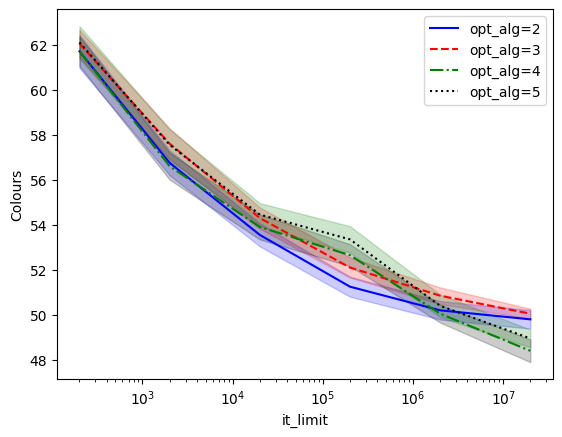

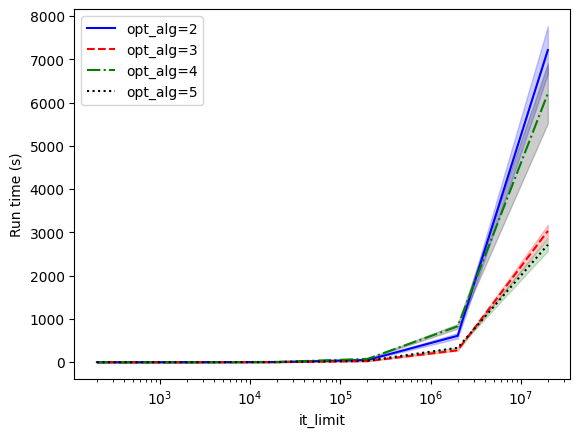

In [4]:
results = []
it_limits = [200, 2000, 20000, 200000, 2000000, 20000000]
for seed in range(20):
    G = nx.gnp_random_graph(500, 0.5, seed)
    for opt_alg in [2, 3, 4, 5]:
        for it_limit in it_limits:
            start = time.time()
            c = gcol.node_colouring(G, opt_alg=opt_alg, it_limit=it_limit)
            results.append([seed, opt_alg, it_limit, max(c.values()) + 1, time.time()-start])

# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["seed", "opt_alg", "it_limit", "cols", "time"])
pivot = df.pivot_table(columns='opt_alg', aggfunc=['mean','std'], values=['cols','time'], index='it_limit')

# Use the pivot table to make charts as before
mean1, SD1 = pivot[("mean","cols",2)], pivot[("std","cols",2)]
mean2, SD2 = pivot[("mean","cols",3)], pivot[("std","cols",3)]
mean3, SD3 = pivot[("mean","cols",4)], pivot[("std","cols",4)]
mean4, SD4 = pivot[("mean","cols",5)], pivot[("std","cols",5)]
plt.plot(it_limits, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=2')
plt.fill_between(it_limits, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(it_limits, mean2, linestyle='--', linewidth=1.5, color="r", label='opt_alg=3')
plt.fill_between(it_limits, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(it_limits, mean3, linestyle='-.', linewidth=1.5, color="g", label='opt_alg=4')
plt.fill_between(it_limits, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(it_limits, mean4, linestyle=':', linewidth=1.5, color="black", label='opt_alg=5')
plt.fill_between(it_limits, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("it_limit")
plt.ylabel("Colours")
plt.legend()
plt.xscale('log')
plt.show()

mean1, SD1 = pivot[("mean","time",2)], pivot[("std","time",2)]
mean2, SD2 = pivot[("mean","time",3)], pivot[("std","time",3)]
mean3, SD3 = pivot[("mean","time",4)], pivot[("std","time",4)]
mean4, SD4 = pivot[("mean","time",5)], pivot[("std","time",5)]
plt.plot(it_limits, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=2')
plt.fill_between(it_limits, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(it_limits, mean2, linestyle='--', linewidth=1.5, color="r", label='opt_alg=3')
plt.fill_between(it_limits, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(it_limits, mean3, linestyle='-.', linewidth=1.5, color="g", label='opt_alg=4')
plt.fill_between(it_limits, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(it_limits, mean4, linestyle=':', linewidth=1.5, color="black", label='opt_alg=5')
plt.fill_between(it_limits, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("it_limit")
plt.ylabel("Run time (s)")
plt.legend()
plt.xscale('log')
plt.show()

Note that the charts above use log scales on their horizontal axes. The first chart shows how using an increased iteration limit can result in solutions that have fewer colors. For very high limits, the hybrid evolutionary algorithms are clearly more favourable. The second chart shows how the iteration limits affect run times with these graphs. 

## Equitable Coloring

In the equitable node-coloring problem, we are interested in coloring the nodes with a user-defined number of colors $k$ so that (a) adjacent nodes have different colors, and (b) the number of nodes in each color is as equal as possible. The following trials run the ``gcol.equitable_node_k_coloring()`` method on a sample of random $G(500,0.5)$ graphs over a range of suitable $k$-values. The reported cost is simply the difference in size between the largest and smallest color classes in a solution. Hence, if $k$ is a divisor of $n$, a cost of zero indicates an equitable $k$-coloring, else a cost of one indicates an equitable coloring.

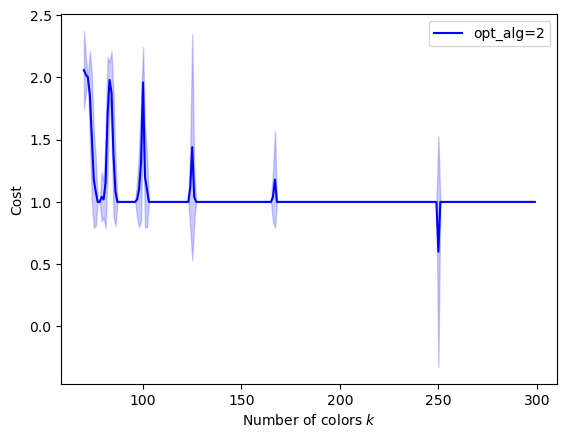

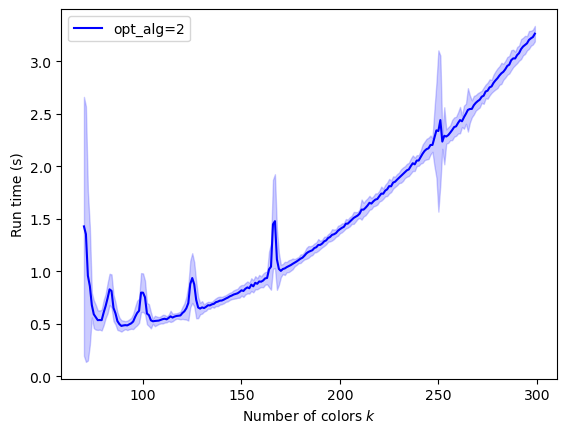

In [5]:
results = []
n = 500
kVals = range(70, 300, 1)
for seed in range(50):
    G = nx.gnp_random_graph(n, 0.5, seed)
    for k in kVals:
        start = time.time()
        c = gcol.equitable_node_k_coloring(G, k, opt_alg=2, it_limit=len(G))
        P = gcol.partition(c)
        cost = max(len(j) for j in P) - min(len(j) for j in P)
        results.append([k, seed, "opt_alg=2", cost, time.time()-start])

# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["k", "seed", "alg", "cost", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['cost','time'], index='k')

# Use the pivot table above to make charts as before
mean1, SD1 = pivot[("mean","cost","opt_alg=2")], pivot[("std","cost","opt_alg=2")]
plt.plot(kVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=2')
plt.fill_between(kVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of colors $k$")
plt.ylabel("Cost")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","opt_alg=2")], pivot[("std","time","opt_alg=2")]
plt.plot(kVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=2')
plt.fill_between(kVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of colors $k$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

The first chart above demonstrates that the ``gcol.equitable_node_k_coloring()`` method consistently achieves equitable node $k$-colorings. The exceptions occur for low values of $k$ (which are close to the chromatic number) and when $k$ is a divisor of $n$. In the former case, the low number of available colors restricts the choice of appropriate colors for each node, often leading to inequitable colorings. On the other hand, when $k$ is a divisor of $n$, the algorithm is seeking a solution with a cost of zero, meaning that each color class must have *exactly* the same number of nodes. If this cannot be achieved, then a cost of at least two must be incurred. 

The second chart above also indicates that runtimes of this routine increase slightly when $k$ is a divisor of $n$. Run times also lengthen due to increases in $k$. The latter is due to the larger number of solutions that need to be evaluated in each iteration of the local search algorithm used with this routine. More details on this algorithm can be found in ``gcol``'s documentation. 

Finally, note that NetworkX [features](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.coloring.equitable_color.html) an exact equitable node $k$-coloring routine, but this can only be used for values of $k\geq \Delta(G)+1$, where $\Delta(G)$ is the highest node degree in the graph. In the $G(500,0.5)$ graphs considered here, the minimum valid value for $k$ is approximately 280.

## Independent Set Comparison

Our final set or trials looks at the performance the ``gcol.max_independent_set()`` routine and compares it to the [approximation algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.maximum_independent_set.html) included in NetworkX for the same problem. As before, we use an iteration limit of $n$ for the former.

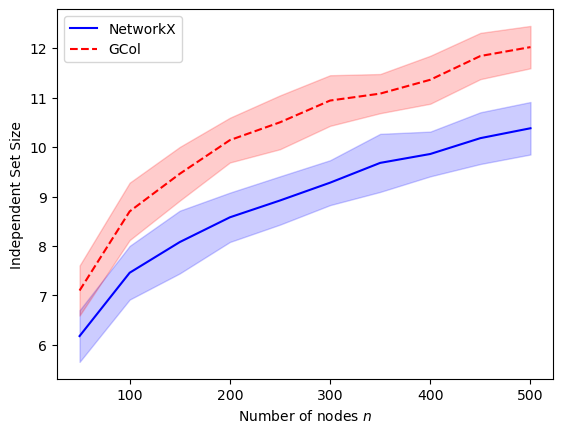

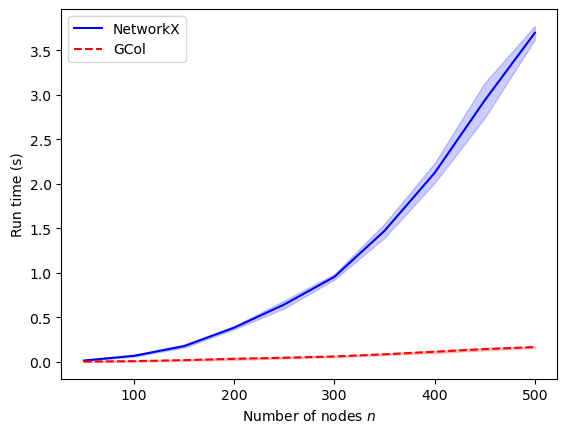

In [6]:
#Carry out the trials and put the results into a list
results = []
nVals = range(50,501,50)
for n in nVals:
    for seed in range(50):
        G = nx.gnp_random_graph(n, 0.5, seed)
        start = time.time()
        S = gcol.max_independent_set(G, it_limit=len(G))
        results.append([n, seed, "gcol", len(S), time.time()-start])
        start = time.time()
        S = nx.approximation.maximum_independent_set(G)
        results.append([n, seed, "networkx", len(S), time.time()-start])
        
# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["n", "seed", "alg", "size", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['size','time'], index='n')

# Create the charts as before
mean1, SD1 = pivot[("mean","size","networkx")], pivot[("std","size","networkx")]
mean2, SD2 = pivot[("mean","size","gcol")], pivot[("std","size","gcol")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='GCol')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Independent Set Size")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","networkx")], pivot[("std","time","networkx")]
mean2, SD2 = pivot[("mean","time","gcol")], pivot[("std","time","gcol")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='GCol')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()        

The results above show quite clearly that the ``gcol.max_independent_set()`` routine produces better quality solutions (larger independent sets) in less run time. As before, further improvements in solution quality (but longer run times) may also be found by increasing the ``it_limit`` parameter. 